In [1]:
import numpy as np
import pandas as pd
import random
import collections
from sklearn.base import clone
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.sparse import coo_matrix
from sklearn.utils import resample
from sklearn.ensemble import VotingClassifier



In [2]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
rs = 0
X, y = make_circles(300, noise=0.1, random_state=rs)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,
random_state=rs)


In [3]:
def plotDataset(X, y):
    for label in np.unique(y):
        plt.scatter(X[y == label, 0], X[y == label, 1], label=label)
    plt.legend()
    plt.show()




In [4]:
def plotEstimator(trX, trY, teX, teY, estimator, title=''):
    estimator = clone(estimator).fit(trX, trY)
    h = .02
    x_min, x_max = teX[:, 0].min() - .5, teX[:, 0].max() + .5
    y_min, y_max = teX[:, 1].min() - .5, teX[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    Z = estimator.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cm, alpha=0.8)
    plt.scatter(teX[:, 0], teX[:, 1], c=teY, cmap=cm_bright, edgecolors='k', alpha=0.6)
    # plt.legend()
    plt.title(title)
    plt.show()

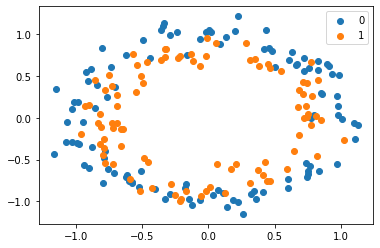

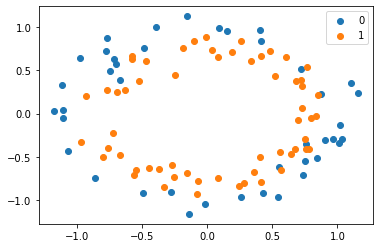

In [5]:
plotDataset(X_train, y_train)
plotDataset(X_test, y_test)

### Decsion Tree

0.6060606060606061


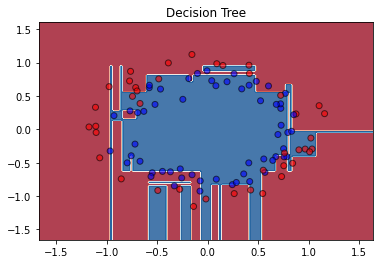

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


estimator = DecisionTreeClassifier(random_state=rs)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
dtAccuracy = accuracy_score(y_test, y_pred)
print(dtAccuracy)
plotEstimator(X_train, y_train, X_test, y_test, estimator, 'Decision Tree')

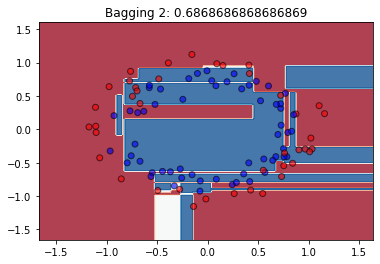

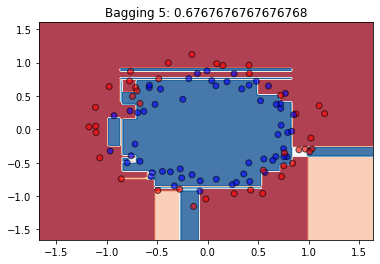

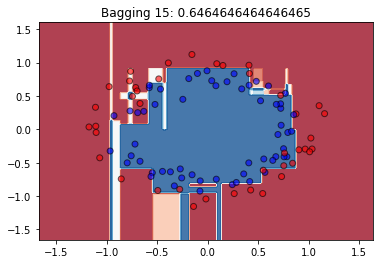

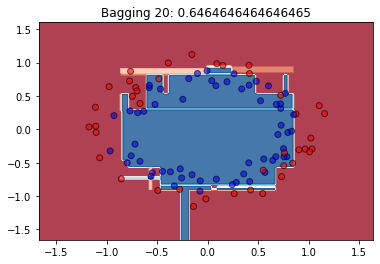

In [7]:
np.random.seed(rs)
for i in [2,5,15,20]:
    estimators=[]
    for j in range(i):
        #Bootstraping dataset using resample function
        X_strapped = coo_matrix(X_train)
        resampled_X, X_strapped, resampled_y = resample(X_train, X_strapped, y_train, random_state=j)
        #Building Bagging on decisiontree
        estimator = DecisionTreeClassifier()
        estimator.fit(resampled_X, resampled_y)
        #array of estimators
        estimators.append(['estimator'+str(j),estimator])
    #Voting Classifier
    voting_clf = VotingClassifier(estimators=estimators, voting='soft')
    voting_clf = voting_clf.fit(X_train, y_train)
    score = voting_clf.score(X_test, y_test)
    plotEstimator(resampled_X, resampled_y, X_test, y_test, voting_clf, f'Bagging {i}: {score}')

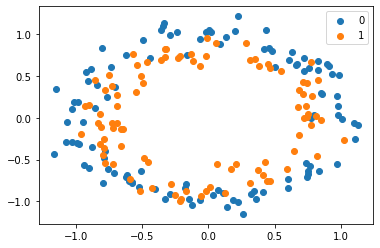

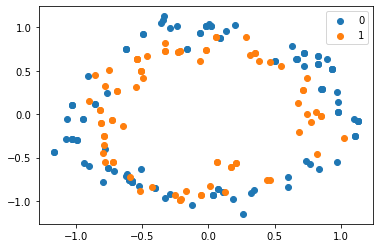

In [8]:


X_bs, y_bs = resample(X_train, y_train, random_state=rs)
plotDataset(X_train, y_train)
plotDataset(X_bs, y_bs)

### Bagging from Scratch

In [9]:
class Bagging():
    def __init__(self, n_estimators=10, max_depth = None):
        
        """
        Intializing the class with it's default paramters 
        defalut number of bootstraped trees is 10 
        maximum depth if not passed will be equal to none
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []
        
    def bagged_data(self, X, y):
        """
        boostrapping dataset by randomizing the the index of the rows as it will be the input of the decision tree
        """
        index = np.random.choice(np.arange(len(X)),len(X))
        return X[index], y[index]

    
    def fit(self, X, y):
        for i in range(self.n_estimators):
            X_bagged, y_bagged = self.bagged_data(X,y)
            new_tree = DecisionTreeClassifier(random_state=rs)
            new_tree.fit(X_bagged,y_bagged)
            self.trees.append(new_tree)
    def predict(self, X):
        """
        Uses the list of tree models built in the fit, The final prediction uses the mode of all the trees predictions.
        """
        self.predicts = []
        for tree in self.trees:
            self.predicts.append(tree.predict(X))
        self.pred_by_row = np.array(self.predicts).T
        
        predictions = []
        for row in self.pred_by_row:
            predictions.append(collections.Counter(row).most_common(1)[0][0])
        return predictions
    def score(self, X, y):
        """
        Uses the predict method to measure the accuracy of the model.
        """
        pred = self.predict(X)
        correct = 0
        for i,j in zip(y,pred):
            if i == j:
                correct+=1
        return float(correct)/float(len(y))

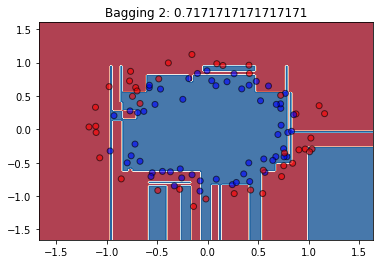

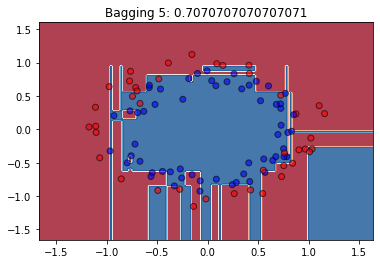

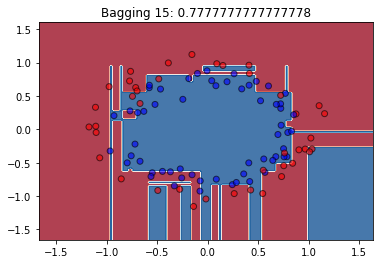

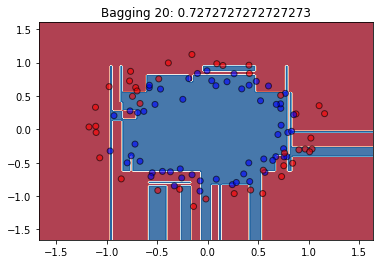

In [10]:
estimators = [2,5,15,20]
np.random.seed(rs)
for nEst in estimators:
    estimator_maded = Bagging()
    estimator_maded.fit(X_train, y_train)
    score = estimator_maded.score(X_test, y_test)
    plotEstimator(X_train, y_train, X_test, y_test, estimator, f'Bagging {nEst}: {score}')

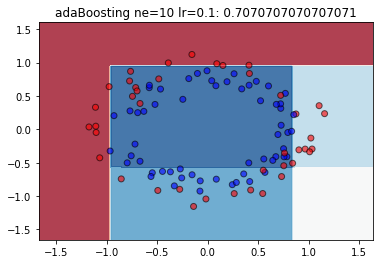

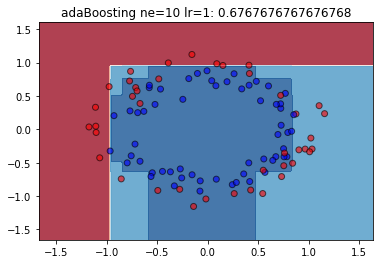

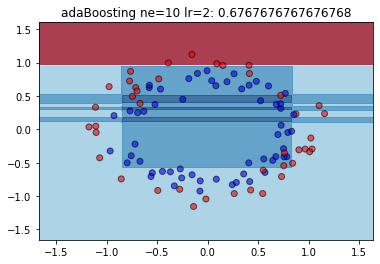

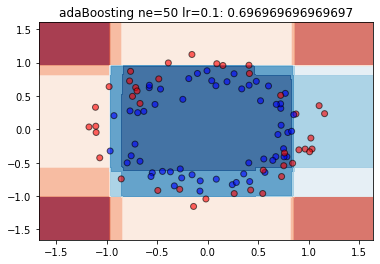

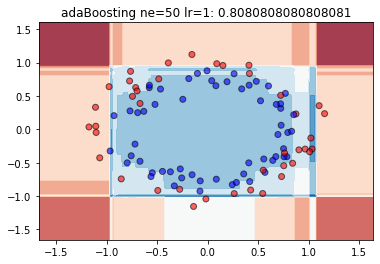

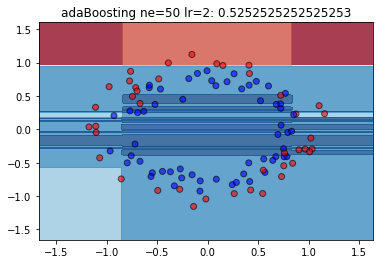

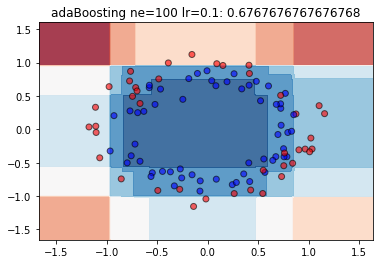

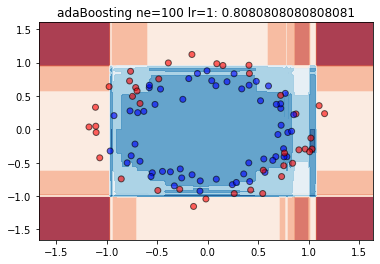

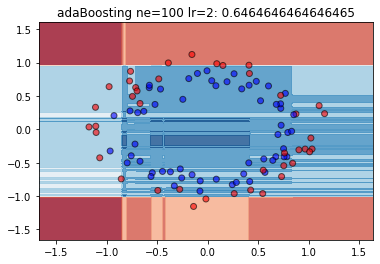

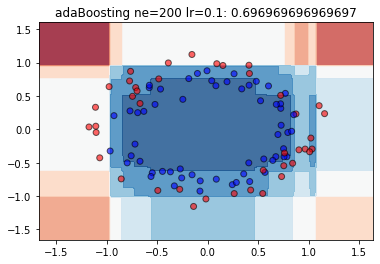

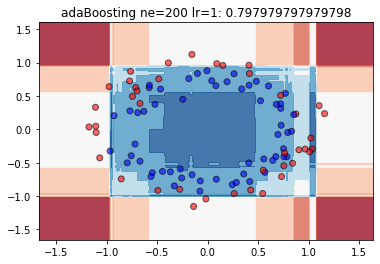

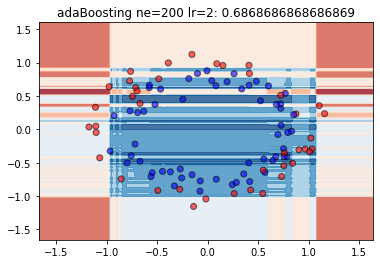

In [13]:
from sklearn.ensemble import AdaBoostClassifier


for estimator in [10,50,100,200]:
    for learning_rate in [0.1,1,2]:
        classifier = AdaBoostClassifier(n_estimators=estimator,learning_rate=learning_rate ,random_state=rs)
        score = classifier.fit(X_train, y_train).score(X_test, y_test)
        plotEstimator(X_train, y_train, X_test, y_test, classifier, f'adaBoosting ne={estimator} lr={learning_rate}: {score}')